# Lecture 2: Spiral classification

- INFO8010 Deep Learning, Gilles Louppe
- Lecture 2: [Multi-layer perceptron](https://glouppe.github.io/info8010-deep-learning/?p=lecture2.md)

This notebook trains a multi-layer perceptron to classify points from a spiral dataset, illustrating the decision boundaries learned by networks of varying depth and width.

*Adapted from [Deep Learning (with PyTorch)](https://github.com/Atcold/pytorch-Deep-Learning) by Alfredo Canziani.*

In [2]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from IPython import display

plt.rcParams['figure.dpi'] = 100
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cpu


In [3]:
def plot_data(X, y, fig=True):
    if fig:
        plt.figure(figsize=(5, 4))
    plt.scatter(X.cpu()[:, 0], X.cpu()[:, 1], c=y.cpu(), s=30)
    plt.axis('square')
    plt.axis((-1.1, 1.1, -1.1, 1.1))
    plt.axis('off')

def plot_model(X, y, model):
    mesh = np.arange(-1.1, 1.1, 0.01)
    xx, yy = np.meshgrid(mesh, mesh)
    with torch.no_grad():
        data = torch.from_numpy(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).float()
        Z = model.cpu()(data).detach()
    Z = np.argmax(Z, axis=1).reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.3)
    plot_data(X, y, fig=False)
    model.to(device)

In [4]:
torch.manual_seed(12345)

N = 100  # samples per class
D = 2    # dimensions
C = 2    # classes
H = 100  # hidden units

In [5]:
X = torch.zeros(N * C, D).to(device)
y = torch.zeros(N * C, dtype=torch.long).to(device)

for c in range(C):
    t = torch.linspace(0, 1, N)
    inner = torch.linspace(
        (2 * np.pi / C) * c,
        (2 * np.pi / C) * (2 + c),
        N
    ) + torch.randn(N) * 0.2
    X[N*c:N*(c+1)] = torch.stack([t * torch.sin(inner), t * torch.cos(inner)], dim=1)
    y[N*c:N*(c+1)] = c

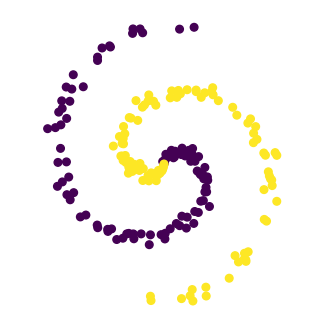

In [6]:
plot_data(X, y)

### Linear model

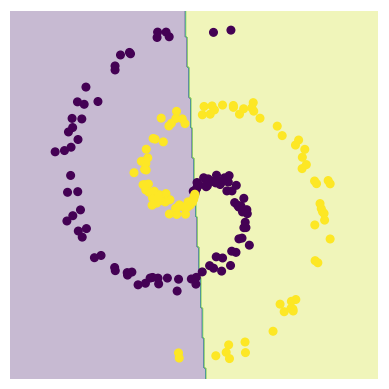

In [7]:
model = nn.Sequential(nn.Linear(D, C)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for t in range(1000):
    y_pred = model(X)
    loss = criterion(y_pred, y)
    acc = (y == y_pred.argmax(1)).float().mean()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if t % 100 == 0:
        plt.clf()
        plot_model(X, y, model)
        model.to(device)
        display.display(plt.gcf())
        print(f"step {t:4d}  loss {loss.item():.4f}  acc {acc:.3f}")
        display.clear_output(wait=True)

### MLP

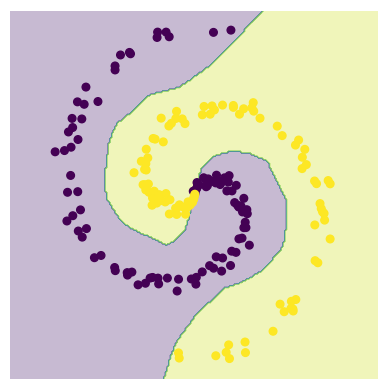

In [8]:
model = nn.Sequential(
    nn.Linear(D, H),
    nn.ReLU(),
    nn.Linear(H, C)
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for t in range(1000):
    y_pred = model(X)
    loss = criterion(y_pred, y)
    acc = (y == y_pred.argmax(1)).float().mean()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if t % 100 == 0:
        plt.clf()
        plot_model(X, y, model)
        model.to(device)
        display.display(plt.gcf())
        print(f"step {t:4d}  loss {loss.item():.4f}  acc {acc:.3f}")
        display.clear_output(wait=True)